<a href="https://colab.research.google.com/github/jacgiard/ComputerVision-project/blob/main/Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision project : Mask Detection

Projet développé par Jacques GIARD et Laurence TSIZAZA, étudiants du Master 2 IASD à Paris Dauphine.

<table class="tfo-notebook-buttons" align="left">

<td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

## Pré-requis

Avant de lancer ce notebook, il est nécessaire de vous assurer de bien avoir accès au données que nous utilisons pour entraîner nos modèles. 
Pour cela, nous conseillons d'ajouter dans votre Google Drive des raccourcis sur les dossiers disponibles aux liens suivant :

*   https://drive.google.com/drive/folders/181xtIQAx0igZQKgxOCwp7H7P4Fz40AbG
*   https://drive.google.com/drive/folders/1c7cmaY-uCAXORnGfyO50vIkUbaj1QNyp
*   https://drive.google.com/drive/folders/1mRSG1AZWI0DVkuk9berDylRrEZTmj7DW?usp=sharing


## Abstract

Le but de se projet est de créer un modèle de réseau de neurones capable de distinguer si une personne sur une photo donnée porte ou non un masque et si, dans le cas elle le porte, le masque est porté convenablement.

Pour ce projet, nous testerons et comparerons deux modèles :
- le premier modèle sera construit et entraîné from scratch;
- le second modèle sera construit et entraîné à partir d'une tâche de Transfer Learning.

## Configuration du notebook et bibliothèques importées

In [ ]:
#@title Chemins d'accès aux données
from google.colab import drive
drive.mount('/content/drive')
# Add a shortcut of the following folders in your drive :
# https://drive.google.com/*drive/folders/181xtIQAx0igZQKgxOCwp7H7P4Fz40AbG
# https://drive.google.com/drive/folders/1c7cmaY-uCAXORnGfyO50vIkUbaj1QNyp
# https://drive.google.com/drive/folders/1mRSG1AZWI0DVkuk9berDylRrEZTmj7DW?usp=sharing
path_mask = "/content/drive/MyDrive/Projets_Dauphine/ComputerVision/1/" #@param {type:"string"}
path_no_mask = "/content/drive/MyDrive/Projets_Dauphine/ComputerVision/0/" #@param {type:"string"}
path_bad_mask = "/content/drive/MyDrive/Projets_Dauphine/ComputerVision/2/" #@param {type:"string"}

Mounted at /content/drive


In [ ]:
#@title import des différentes bibliothèques et version de tensorflow
import os

# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

#For building Deep learning models
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Faor sampling the datasets
from random import sample

from skimage.io import imread
import cv2

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.5.0
The following GPU devices are available: /device:GPU:0


## Importation et configuration des datasets

In [ ]:
width, height = 299, 299 # We resize every image to a chosen size

In [ ]:
# generation of the dataset

# load images of people wearing mask and add them the label [0, 1, 0], meaning they belong to the class 1
masks = [(cv2.resize(cv2.cvtColor(cv2.imread(path_mask+x), cv2.COLOR_BGR2RGB), (width, height), interpolation = cv2.INTER_AREA), [0,1,0]) for x in os.listdir(path_mask)]

# load images of people not wearing mask and add them the label [1, 0, 0], meaning they belong to the class 0
no_masks = [(cv2.resize(cv2.cvtColor(cv2.imread(path_no_mask+x), cv2.COLOR_BGR2RGB), (width, height), interpolation = cv2.INTER_AREA), [1,0,0]) for x in os.listdir(path_no_mask)]

# load images of people wearing wrongly their mask and add them the label [0, 0, 1], meaning they belong to the class 2
bad_masks = [(cv2.resize(cv2.cvtColor(cv2.imread(path_bad_mask+x), cv2.COLOR_BGR2RGB), (width, height), interpolation = cv2.INTER_AREA), [0,0,1]) for x in os.listdir(path_bad_mask)]

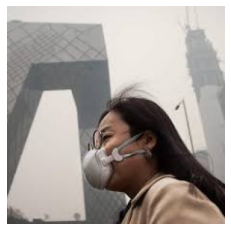

In [ ]:
#@title Exemple de personne portant un masque
plt.figure()
plt.imshow(masks[0][0]) # example of a person wearing a mask
plt.axis('off')
plt.show()

In [ ]:
dataset = masks + no_masks + bad_masks  # generate the full dataset with the 3 subsets
np.random.shuffle(dataset)  # suffle the dataset

In [ ]:
from sklearn.model_selection import train_test_split
testsize = 0.2

# Spliting the dataset into Training, Validation and Testing sets
X_train, X_test, y_train, y_test = train_test_split([x[0] for x in dataset], [x[1] for x in dataset], random_state=42, test_size=testsize)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, test_size=testsize)

# converting the sets into numpy array for easier uses
X_train, X_validation, X_test, y_train, y_validation, y_test = np.array(X_train), np.array(X_validation), np.array(X_test), np.array(y_train), np.array(y_validation), np.array(y_test) 

In [ ]:
# We will add transformed images to our training set by doing flips and rotations over our training images in order to have a stronger model
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

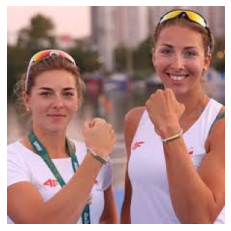

In [ ]:
#@title Exemple d'image du dataset d'entraînement
plt.figure()
plt.imshow(X_train[0])  # example of a training image
plt.axis('off')
plt.show()

## Définition et entraînement du modèle from scratch




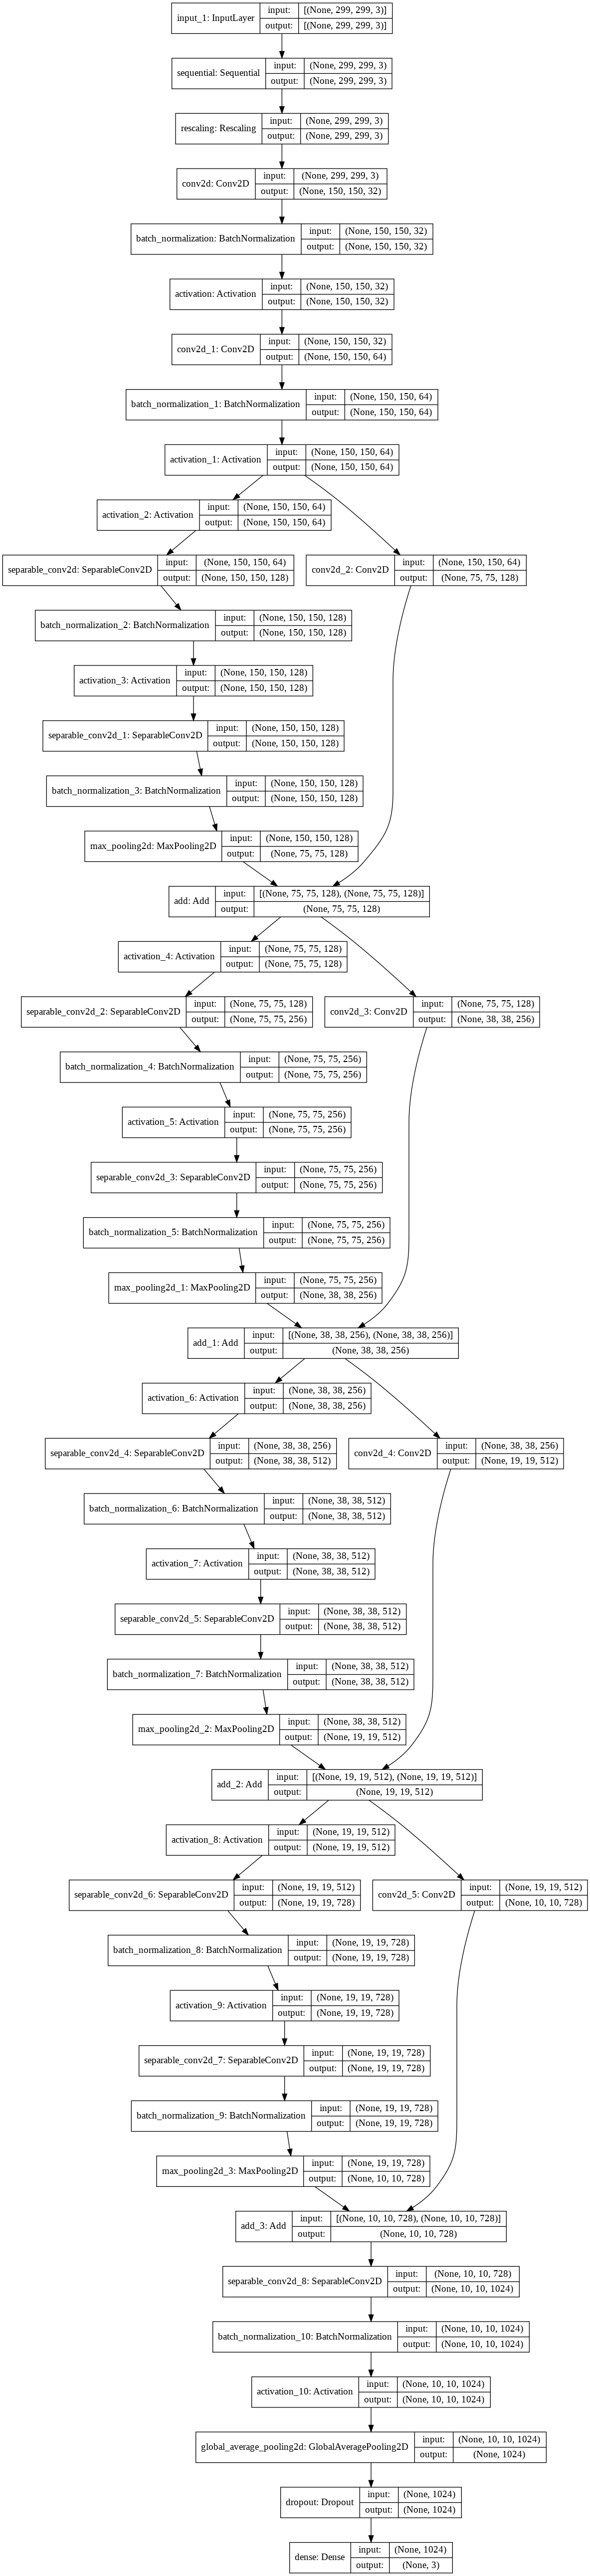

In [ ]:
#@title Définition et architecture du modèle utilisé
input_shape = (width, height, 3)  # input shape of the model

def make_model(input_shape, num_classes):
    '''
    Function that defines a deep learning model for image classification
    '''
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# make a classification model for 3 classes : no mask, mask, mask badly wore
model = make_model(input_shape=input_shape, num_classes=3)
# plot the model architecture
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def compile_and_train_model(model, epochs):
  # compile the model
  model.compile(
      optimizer=keras.optimizers.Adam(1e-3),
      # the problem is a classification problem, therefore we use the categorical-crossentropy loss
      loss="categorical_crossentropy", 
      metrics=["accuracy"],
  )
  # We then fit the model on our training data, with validation over the validation dataset
  model.fit(
      X_train, y_train, epochs=epochs,  
      validation_data=(X_validation, y_validation),
      verbose=1
  )

  return model.evaluate(X_validation, y_validation)

epochs = 20

compile_and_train_model(model, epochs)

Epoch 1/20
46/46 [==============================] - 71s 764ms/step - loss: 0.6433 - accuracy: 0.7157 - val_loss: 1.1092 - val_accuracy: 0.3158
Epoch 2/20
46/46 [==============================] - 32s 692ms/step - loss: 0.4702 - accuracy: 0.7684 - val_loss: 1.1588 - val_accuracy: 0.3158
Epoch 3/20
46/46 [==============================] - 32s 705ms/step - loss: 0.4188 - accuracy: 0.7926 - val_loss: 1.2346 - val_accuracy: 0.3158
Epoch 4/20
46/46 [==============================] - 33s 709ms/step - loss: 0.3822 - accuracy: 0.8031 - val_loss: 1.2807 - val_accuracy: 0.3158
Epoch 5/20
46/46 [==============================] - 32s 701ms/step - loss: 0.3851 - accuracy: 0.8121 - val_loss: 1.3902 - val_accuracy: 0.3158
Epoch 6/20
46/46 [==============================] - 33s 708ms/step - loss: 0.4590 - accuracy: 0.7906 - val_loss: 2.1857 - val_accuracy: 0.3490
Epoch 7/20
46/46 [==============================] - 32s 706ms/step - loss: 0.4935 - accuracy: 0.7621 - val_loss: 2.1352 - val_accuracy: 0.3047

[0.8569843173027039, 0.6260387897491455]

## Définition et entraînement du modèle par Transfer Learning (avec le modèle Xception)

Nous avons testé plusieurs modèles pré-entraînés pour la tâche de Machine Learning : VGG16, VGG19 et Xception. Chaque modèle avait pour tâche principale de classifier des images avec un ensemble de 1000 classes différentes. 

Alors que les modèles VGG16 et VGG19 permettaient d'atteindre des performances de 75%, le modèle Xception nous a fait atteindre un score de 98%.


83689472/83683744 [==============================] - 0s 0us/step


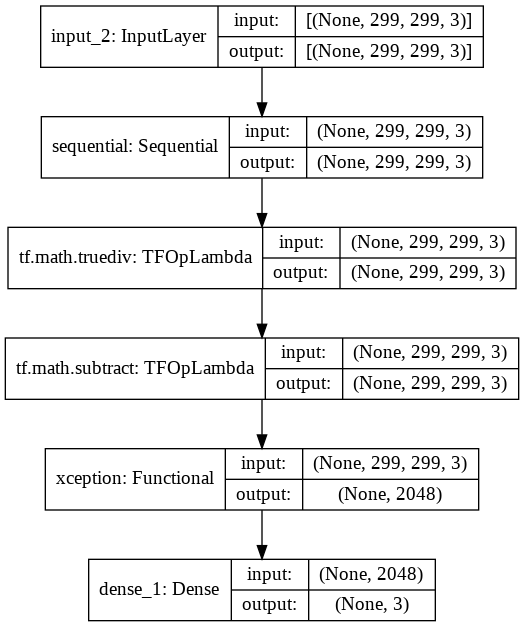

In [ ]:
#@title Définition et architecture du modèle utilisé

input_shape = (width, height, 3)

def make_transfer_learning_model(input_shape, num_classes):
    '''
    This function defines a deep learning model that uses the
    pre-trained Xception model.
    Source : https://arxiv.org/abs/1610.02357
    '''
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    # Pre-processing of the images, scales each pixel between -1 and 1
    x = xception_preprocess(x)

    # Pre-trained part of the model
    tl_layer = Xception(include_top=False, input_shape=input_shape,
                        pooling='avg')(x)
    tl_layer.trainable = False

    # Output layer
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    outputs = keras.layers.Dense(units, activation=activation)(tl_layer)
    return keras.Model(inputs, outputs)


transfer_learning_model = make_transfer_learning_model(input_shape=input_shape, num_classes=3)
keras.utils.plot_model(transfer_learning_model, show_shapes=True)

In [ ]:
compile_and_train_model(transfer_learning_model, epochs)

Epoch 1/20
46/46 [==============================] - 65s 1s/step - loss: 0.2150 - accuracy: 0.9168 - val_loss: 3.8335 - val_accuracy: 0.8227
Epoch 2/20
46/46 [==============================] - 56s 1s/step - loss: 0.1734 - accuracy: 0.9494 - val_loss: 4.9601 - val_accuracy: 0.7507
Epoch 3/20
46/46 [==============================] - 56s 1s/step - loss: 0.0883 - accuracy: 0.9667 - val_loss: 0.1076 - val_accuracy: 0.9612
Epoch 4/20
46/46 [==============================] - 56s 1s/step - loss: 0.1427 - accuracy: 0.9570 - val_loss: 3.9368 - val_accuracy: 0.6870
Epoch 5/20
46/46 [==============================] - 56s 1s/step - loss: 0.0904 - accuracy: 0.9681 - val_loss: 0.3997 - val_accuracy: 0.9418
Epoch 6/20
46/46 [==============================] - 56s 1s/step - loss: 0.1631 - accuracy: 0.9376 - val_loss: 5.0336 - val_accuracy: 0.7396
Epoch 7/20
46/46 [==============================] - 58s 1s/step - loss: 0.0849 - accuracy: 0.9702 - val_loss: 0.3388 - val_accuracy: 0.9114
Epoch 8/20
46/46 [==

[0.15462593734264374, 0.9612188339233398]

## Evaluation des modèles

Si nous bservons parfois des résultats peu convainquant, ceci est sûrement dû à une fluctuation de l'accuracy sur les dataset de validation. Nous pensons que la data augmentation pourrait expliquer cette vaariation. 

Le modèle from scratch peut atteindre une accuracy de 90%.
Le modèke par Transfer Learning peut atteindre une accuracy de 98%.

Performance du modèle entrainé from scratch
Accuracy on the dataset : 60%


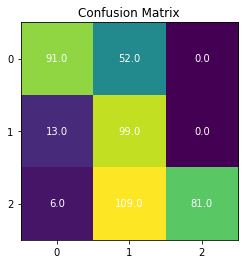

Performance du modèle entrainé par Transfer Learning
Accuracy on the dataset : 97%


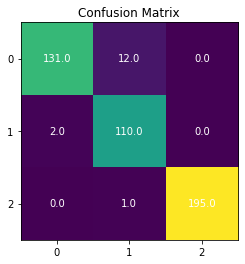

array([[131.,  12.,   0.],
       [  2., 110.,   0.],
       [  0.,   1., 195.]])

In [ ]:
#@title Accuracy et matrice de confusion des modèles

def plot_confusion_matrix(matrix):
  n,_ = matrix.shape
  _, ax = plt.subplots()
  im = ax.imshow(matrix)
  ax.set_xticks(np.arange(n))
  ax.set_yticks(np.arange(n))
  for i in range(n):
      for j in range(n):
          text = ax.text(j, i, matrix[i, j],
                         ha="center", va="center", color="w")
  ax.set_title("Confusion Matrix")
  plt.show()
  return 

def get_model_performance(model, x=X_test, y=y_test):
  y_test = np.array([np.where(r==1)[0][0] for r in y])
  y_pred = model.predict(x)
  y_pred = np.array([np.argmax(r) for r in y_pred])
  print("Accuracy on the dataset : {:.0f}%".format(100.*np.mean(y_test==y_pred)))
  n_classes = max(y_test)+1
  confusion_matrix = np.zeros((n_classes, n_classes))
  for i in range(n_classes):
    for j in range(n_classes):
      confusion_matrix[i][j] = sum([(y_test[idx]==i and y_pred[idx]==j) for idx in range(y_test.shape[0])])
  plot_confusion_matrix(confusion_matrix)
  return confusion_matrix

print("Performance du modèle entrainé from scratch")
get_model_performance(model)

print("Performance du modèle entrainé par Transfer Learning")
get_model_performance(transfer_learning_model)

In [ ]:
y_pred = model.predict(X_test)  # we can measure the performance of our model with the test set

In [ ]:
confiance = [x[0] and x[1] for x in (np.round(y_pred).reshape(y_test.shape) == y_test)] # data where the prediction is good

print("Accurary on the test set :", 100 * sum(confiance)/len(confiance), "%")

Accurary on the test set : 61.41906873614191 %


## Exemples de prédictions des modèles

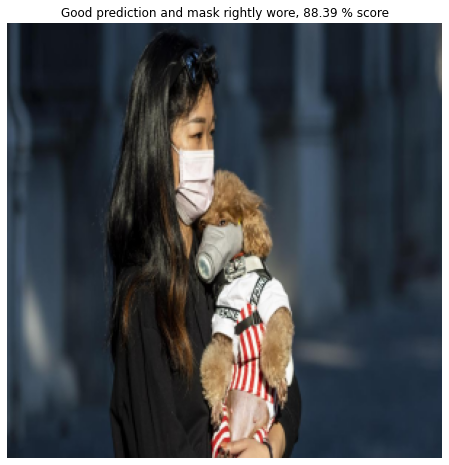

Prediction to have the mask on according to the Transfer Learning model : 100.00% 


In [ ]:
#@title Exemple de bonne prédiction de personne portant un masque
import random

def get_model_random_prediction(X, y, model, classe, good=True):
  classes = ["no mask", "mask rightly wore", "mask wrongly wore"]
  indices = [i for i,vec in enumerate(y) if vec[classe] == 1]
  x_sample = [img for i,img in enumerate(X) if i in indices]
  y_pred = model.predict(np.array(x_sample))
  y_class_pred = np.array([np.argmax(r) for r in y_pred])
  title = ""
  if good :
    correct_indices = [i for i,p in enumerate(y_class_pred) if p == classe]
    idx = random.choice(correct_indices)
    title = "Good prediction and {}, {:.2f} % score".format(classes[classe], y_pred[idx][classe] * 100)
  else :
    correct_indices = [i for i,p in enumerate(y_class_pred) if p != classe]
    idx = random.choice(correct_indices)
    prediction = y_class_pred[idx]
    title = "Bad prediction and {}, predicted as {} with probability of {:.2f}%".format(classes[classe],
                                                                                        classes[prediction],
                                                                                        100*y_pred[idx][prediction])
  
  plt.figure(figsize=(16,8))
  plt.imshow(x_sample[idx])

  plt.title(title)
  plt.axis('off')
  plt.show()
  return x_sample[idx]



"""
good_mask = np.where(confiance)[0]
choice = random.choice(good_mask)
while y_test[choice][1] != 1:
  choice = random.choice(good_mask)
good_mask = X_test[choice]
plt.figure(figsize=(16,8))
plt.imshow(good_mask)
plt.title("Good prediction and mask on, {:.2f} % score".format(y_pred[choice][1] * 100) )
plt.axis('off')
plt.show()
"""

good_mask = get_model_random_prediction(X_test, y_test, model, 1, good=True)
good_mask_pred = transfer_learning_model.predict(np.array([good_mask]))[0][1]
print("Prediction to have the mask on according to the Transfer Learning model : {:.2f}% "
      .format(100. * good_mask_pred))

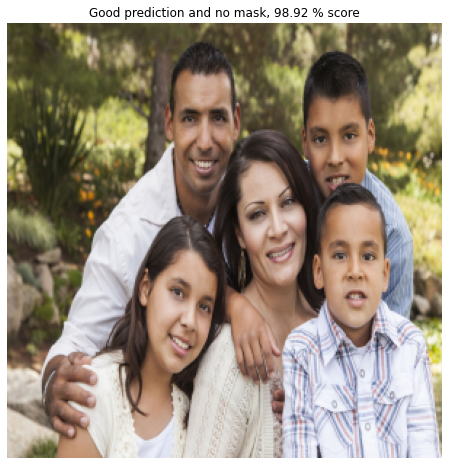

Prediction to have no mask on according to the Transfer Learning model : 100.00% 


In [ ]:
#@title Exemple de bonne prédiction de personne ne portant pas de masque
"""
good_no_mask = np.where(confiance)[0]
choice = random.choice(good_no_mask)
while y_test[choice][0] != 1:
  choice = random.choice(good_no_mask)
good_no_mask = X_test[choice]
plt.figure(figsize=(16,8))
plt.imshow(good_no_mask)
plt.title("Good prediction and no mask, {:.2f} % score".format(y_pred[choice][0] * 100) )
plt.axis('off')
plt.show()
"""

good_no_mask = get_model_random_prediction(X_test, y_test, model, 0)
good_no_mask_pred = transfer_learning_model.predict(np.array([good_no_mask]))[0][0]
print("Prediction to have no mask on according to the Transfer Learning model : {:.2f}% "
      .format(100. * good_no_mask_pred))

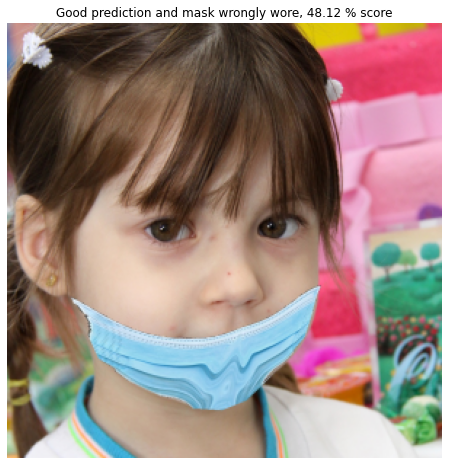

Prediction to have the mask wrongly wore on according to the Transfer Learning model : 100.00% 


In [ ]:
#@title Exemple de bonne prédiction de personne portant mal son masque
"""
good_bad_mask = np.where(confiance)[0]
choice = random.choice(good_bad_mask)
while y_test[choice][2] != 1:
  choice = random.choice(good_bad_mask)
good_bad_mask = X_test[choice]
plt.figure(figsize=(16,8))
plt.imshow(good_bad_mask)
plt.title("Good prediction and mask wrongly wore, {:.2f} % score".format(y_pred[choice][2] * 100) )
plt.axis('off')
plt.show()
"""

good_bad_mask = get_model_random_prediction(X_test, y_test, model, 2)
good_bad_mask_pred = transfer_learning_model.predict(np.array([good_bad_mask]))[0][2]
print("Prediction to have the mask wrongly wore on according to the Transfer Learning model : {:.2f}% "
      .format(100. * good_bad_mask_pred))

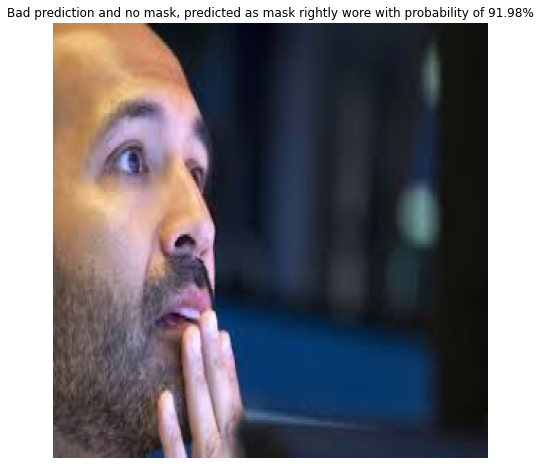

Prediction to have no mask on according to the Transfer Learning model : 39.32% 


In [ ]:
#@title Exemple de mauvaise prédiction

'''bad_mask = np.where([x == False for x in confiance])[0]
choice = random.choice(bad_mask)
#while y_test[choice][1] != 1:
 # choice = random.choice(bad_mask)
bad_mask = X_test[choice]
plt.figure(figsize=(16,8))
plt.imshow(bad_mask)
prediction = ["no mask", "mask on", "mask wrongly wore"]
score = max(y_pred[choice])
idx = np.where(y_pred[choice]==score)[0][0]
plt.title("Bad prediction and " + prediction[idx] + ", {:.2f} % score".format(score * 100) )
plt.axis('off')
plt.show()'''

bad_prediction_img = get_model_random_prediction(X_test, y_test, model, 0, good=False)
pred = transfer_learning_model.predict(np.array([bad_prediction_img]))[0][0]
print("Prediction to have no mask on according to the Transfer Learning model : {:.2f}% "
      .format(100. * pred))

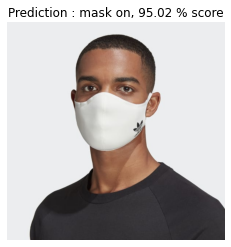

Modele from scratch
Probability that there is no mask : 4.82 %
Probability that there is a mask : 95.02 %
Probability that there is a mask that is wrongly wore : 0.16 %
Transfer Learning Model
Probability that there is no mask : 0.00 %
Probability that there is a mask : 100.00 %
Probability that there is a mask that is wrongly wore : 0.00 %


In [ ]:
#@title Utilisation du réseau sur une image quelconque sur internet

import requests
URL_image = "https://assets.adidas.com/images/w_600,f_auto,q_auto/8f486b0278264d6598cbac56017bd0e9_9366/Masque_M-L_(3_articles)_Blanc_HB7850.jpg" #@param {type:"string"}
response = requests.get(URL_image)

file = open("sample_image.jpg", "wb")
file.write(response.content)
file.close()

image = cv2.cvtColor(cv2.imread("sample_image.jpg"), cv2.COLOR_BGR2RGB)
img = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)


y = model.predict(np.array([img]))[0]
tly = transfer_learning_model.predict(np.array([img]))[0]

plt.figure()
prediction = ["no mask", "mask on", "mask wrongly wore"]
score = max(y)
idx = np.where(y==score)[0][0]

plt.imshow(image)
plt.title("Prediction : " + prediction[idx] + ", {:.2f} % score".format(score * 100) )
plt.axis('off')
plt.show()

print("Modele from scratch")
print("Probability that there is no mask : {:.2f} %".format(y[0] * 100))
print("Probability that there is a mask : {:.2f} %".format(y[1] * 100))
print("Probability that there is a mask that is wrongly wore : {:.2f} %".format(y[2] * 100))

print("Transfer Learning Model")
print("Probability that there is no mask : {:.2f} %".format(tly[0] * 100))
print("Probability that there is a mask : {:.2f} %".format(tly[1] * 100))
print("Probability that there is a mask that is wrongly wore : {:.2f} %".format(tly[2] * 100))

## Conclusion

Pour cette tâche de classification de personnes porteuses de masques, nos expériences ont montré qu'un modèle créé et entraîné à partir de rien arrive a concurrencer un modèle basé sur du Transfer Learning, malgré que le modèle de Transfer Learning atteint beaucoup plus rapidement point optimal.

Cependant, si nous souhaitions aller plus loin, nous aurions pu faire de la détection de classe pour les mêmes classes, car en situation réelle, il se pourrait que toutes les personnes sur une même photo n'appartiennent pas à la même catégorie.